In [1]:
import scipy as sp
import pandas as pd
import numpy as np
import scipy as sp
import re
import os
import json
import sys
import multiprocessing
from tqdm import tqdm
import random

from konlpy.tag import Kkma
from konlpy.tag import Hannanum
from konlpy.tag import Okt
from eunjeon import Mecab  # KoNLPy style mecab wrapper

from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import platform
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

from bs4 import BeautifulSoup
from urllib.request import urlopen
import urllib
import time

from tqdm import tqdm_notebook
import nltk
from nltk.tokenize import word_tokenize

import gensim
from gensim.test.utils import common_texts
from gensim.models import word2vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from matplotlib import font_manager, rc


In [3]:
def get_tokenizer(tokenizer_name):
    if tokenizer_name == "okt":
        tokenizer = Okt()
    elif tokenizer_name == "mecab":
        tokenizer = Mecab()
    elif tokenizer_name == "hannanum":
        tokenizer = Hannanum()
    elif tokenizer_name == "kkma":
        tokenizer = Kkma()
    else:
        tokenizer = Mecab()
    return tokenizer

time_list = []
tokenizer_list = ["komoran", "okt", "mecab", "hannanum", "kkma"]
for i in tokenizer_list:
    start = time.time()
    tokenizer = get_tokenizer(i)
    tokenizer.morphs("""한국어 자연어 처리 분야에 정말 괜찮은 책이 나왔다 출간되자 마자 읽어 보고 저자의 내
    공에 참 놀랐다 이렇게 좋은 품질의 도서가 더 많이 나와야 한다고 생각하는 입장에서 저자에게 고마울 따름이
    다 하지만 네이버 책정보에도 YES24에도 이제까지 연결된 리뷰가 하나도 없다는 점이 좀 의아했다 네이버 블로그
    리뷰는 좀 있음에도 그 이유는 아마도 책 제목 때문이 아닐까 싶었다 아무래도 입문자 분들이 많이 봐야 할텐데
    인공지능이나 딥러닝 같은 키워드가 아닌 한국어 임베딩이라고 제목이 달려있으니 뭔가 다른 기술이거나 아니면 
    매우 작은 범위의 기술로 착각할 수 있기 때문이다 임베딩은 자연어 처리 뿐만 아니라 컴퓨터 비전 음성에서도 
    매우 중요한 키워드가 됐다 나 같은 경우 딥러닝 공부 초창기에 GAN에서 임베딩이라는 개념을 처음 접하게 되었는
    데 이걸 이해하려고 고생했던 기억이 있다 딥러닝을 공부하면 할 수록 임베딩이라는 용어는 여러 개념을 관통하는
    너무나 중요한 용어다. 이 책은 최신 자연어 처리 기술을 포함하고 있으며 이를 한국어에 맞게 적용할 수 있도록 
    일목요연하게 설명한 책이다 특히 저자의 언어로 이러한 기술들을 설명한 점이 가장 중요하다 최근 자연어 처리
    기술이 BERT를 통해 퀀텀 점프를 하였고 XLNet과 같은 후속 연구가 빠르게 진행되면서 급속하게 발전하고 있다 
    저자는 BERT까지만 다루었는데 XLNet 같은 경우 직접 실험해보니 BERT보다 성능이 부족하다 판단하여 제외했다는
    언급이 있다 이러한 부분이 책의 신뢰성을 더 높인다고 생각한다 직접 실험해보고 고민해보고 이해한 흔적이 저자
    만의 언어로 설명되면 독자는 더 많은 통찰을 얻을 수 있다 데이터를 다루는 부분부터 소스코드도 괜찮고 그림 설
    명도 훌륭하다 다만 코드를 마이크로하게 설명하는 부분은 부족하여 입문자 분들에겐 힘들수도 있지만 그래도 중요
    한 부분은 모두 언급했기 때문에 나쁘지 않다고 생각한다 한국어 용어도 내 입장에서는 매우 마음에 들었다 영어 
    발음 그대로 한국어로 쓰는 것을 싫어하시는 분들도 계시겠지만 결국 최신 기술은 영어 논문을 읽어야 하기 때문에
    어설프게 한국어로 번역된 용어 보다 훨씬 낫다고 생각한다 처음 나오는 전문용어 옆에는 영어로 표시하여 헷갈리
    지 않도록 충분히 배려했다 제발 다른 번역서도 이 책을 참고하여 어설프게 한국어로 번역하지 않았으면 하는 바람
    이다 자연어 처리의 딥러닝 기술을 매우 잘 설명한 좋은 책이다 아직 리뷰가 하나도 없지만 더 많은 리뷰도 달리고
    더 잘 팔려서 최신 기술을 담은 2판이 나오길 희망한다""")
    time_required = time.time() - start
    tokenizer_and_time = i, time_required
    time_list.append(tokenizer_and_time)
aa = pd.DataFrame(time_list, columns = ['토크나이저', '토큰화 소요시간'])
print(aa)

      토크나이저  토큰화 소요시간
0   komoran  0.011408
1       okt  2.693230
2     mecab  0.044639
3  hannanum  0.672576
4      kkma  5.287853


In [3]:
def get_data(path):
    df_result = pd.read_csv('./2020Samsung/2020-01-01Samsung.csv')
    date_index = pd.date_range(start='20200102', end='20201231')
    date_list = date_index.strftime("%Y-%m-%d").tolist()

    for date in date_list:
        df_next = pd.read_csv('./2020Samsung/%sSamsung.csv'%date)
        df_result = pd.concat([df_result,df_next],ignore_index=True)
    return df_result

df_result = get_data('./2020Samsung')
df_result

,Unnamed: 0,회사명,날짜,언론사,기사제목,링크,본문
0,0,삼성전자,2020-01-0122:05,노컷뉴스,삼성 반도체공장 1분 정전 피해 수십억…복구 2~3일 걸릴 듯,https://finance.naver.com/news/news_read.nhn?a...,[' 삼성 반도체공장 1분 정전 피해 수십억…복구 2~3일 걸릴 듯 ...
1,1,삼성전자,2020-01-0120:43,경향신문,삼성 vs LG ‘우리 냉장고가 더 똑똑해’,https://finance.naver.com/news/news_read.nhn?a...,"["" 삼성 vs LG ‘우리 냉장고가 더 똑똑해’ 기사입력202..."
2,2,삼성전자,2020-01-0120:43,경향신문,삼성 vs LG ‘8K TV 전쟁’ 일단락?,https://finance.naver.com/news/news_read.nhn?a...,"["" 삼성 vs LG ‘8K TV 전쟁’ 일단락? 기사입력202..."
3,3,삼성전자,2020-01-0120:39,JTBC,삼성전자 반도체 공장서 '1분 정전'…최소 수십억 피해,https://finance.naver.com/news/news_read.nhn?a...,[' 삼성전자 반도체 공장서 \'1분 정전\'…최소 수십억 피해 ...
4,4,삼성전자,2020-01-0120:30,채널A,"반도체 공장, 1분 정전에도 피해액은 수십억 원",https://finance.naver.com/news/news_read.nhn?a...,"[' 반도체 공장, 1분 정전에도 피해액은 수십억 원 기사입력2..."
...,...,...,...,...,...,...,...
75991,10,삼성전자,2020-12-3100:20,뉴시스,글로벌 스마트폰 판매량 2개월 만에 재반등...애플 신모델 효과,https://finance.naver.com/news/news_read.nhn?a...,[' 글로벌 스마트폰 판매량 2개월 만에 재반등...애플 신모델 효과 ...
75992,11,삼성전자,2020-12-3100:11,이데일리,단연 돋보인 韓 증시…올해 상승률 G20 중 1위,https://finance.naver.com/news/news_read.nhn?a...,[' 단연 돋보인 韓 증시…올해 상승률 G20 중 1위 기사입력...
75993,12,삼성전자,2020-12-3100:04,중앙일보,드디어 ‘8만전자’…동학개미도 만세,https://finance.naver.com/news/news_read.nhn?a...,"["" 드디어 ‘8만전자’…동학개미도 만세 기사입력2020-12-..."
75994,13,삼성전자,2020-12-3100:04,중앙일보,"테슬라 수익률 670%, 니오 1140%…서학개미 ‘만세’",https://finance.naver.com/news/news_read.nhn?a...,"["" 테슬라 수익률 670%, 니오 1140%…서학개미 ‘만세’ ..."


In [4]:
print((df_result.loc[:,'본문'][22110]))

[]


In [5]:
def preprocessing(news_main):
    news_data = []
    for i in tqdm(range(len(news_main))):
    #     check empty
        if len(news_main.loc[:,'본문'][i]) == 2:
            continue
        data = news_main.loc[:,'본문'][i].split("댓글")[1]
        data = data.split("@")[0].strip()
        content_text = re.sub(r'\([^)]*\)', '', data)
        news_data.append([content_text,news_main.loc[:,'링크'][i]])
    return news_data

news_data = preprocessing(df_result)
news_data

100%|█████████████████████████████████████████████████████████████████████████| 75996/75996 [00:04<00:00, 16776.29it/s]


[['[CBS노컷뉴스 최인수 기자]삼성전자 화성 사업장. 지난달 31일 오후 발생한 경기도 화성 일대 정전으로 삼성전자 화성캠퍼스 반도체 생산라인의 일부 가동이 중단되면서 피해 규모가 수십억원 정도로 추정되고 있다.1일 업계 등에 따르면, 전날 오후 1시 30분쯤 화성시의 한 변전소에서 송전 케이블이 터지면서 발생한 1~2분의 전력 공급 중단으로 화성사업장 생산라인 일부 가동은 1분여간 중단됐다. 화성 사업장은 D램과 낸드플래시 등 삼성의 메모리 반도체 생산 주요 기지다.이번 정전에서 정전 대비 장치가 작동했지만, 반도체 공정은 한번 가동이 중단되면 재가동까지 일정 시간이 소요되고 비상발전 설비에만 의존하기도 쉽지 않은 것으로 알려졌다.업계 안팎에서는 이번 정전에 따른 피해 규모가 수십억원정도로 추정하고 있다.앞서 지난해 3월 삼성전자 평택 사업장 정전사고 때는 자체 운용하는 내부 변전소 문제로 28분간 정전이 이어졌다. 이로 인한 피해는 500억원 수준이었다.삼성전자는 현재 해당 생산라인 복구 작업을 진행 중이며 완전 복구에는 2∼3일가량 소요될 것으로 예상된다.▶ 확 달라진 노컷뉴스▶ 인싸들의 선택, 노컷뉴스 구독 서비스▶ 노컷이 못한 일, 돈컷은 한다apple',
  'https://finance.naver.com/news/news_read.nhn?article_id=0003307266&office_id=079&mode=search&query=삼성전자&page=1'],
 ['ㆍ‘CES 2020’에서 AI 기술 대결2020년형 삼성 ‘패밀리허브 냉장고’와 LG ‘인스타뷰 씽큐’ 냉장고.삼성전자와 LG전자가 오는 7일부터 10일까지 미국 라스베이거스에서 열리는 세계 최대 가전·IT 전시회 ‘CES 2020’에서 똑똑한 인공지능 냉장고 대결을 펼친다.삼성전자는 올해 CES에서 한 단계 진화한 인공지능이 적용된 ‘패밀리 허브’ 냉장고 신제품을 공개한다고 1일 밝혔다. 이 제품에는 ‘푸드 AI’가 적용돼 사전에 선호하는 음식을 등록해놓으면 맞춤형 식단과 요리법을 

In [6]:
train, test = train_test_split(news_data, test_size = 0.2)
print(len(train))
print(len(test))

60796
15199


In [7]:
news_text = ''
for each_line in news_data[:10000]:
    news_text = news_text + each_line[0] + '\n'
mecab = Mecab()
tokens_news = mecab.morphs(news_text)
ko = nltk.Text(tokens_news, name='뉴스')
print(len(ko.tokens))
print(len(set(ko.tokens)))

5091010
41322


In [10]:
ko = nltk.Text(tokens_news, name='뉴스')
ko.vocab().most_common(100)

[('.', 172680),
 ('다', 123341),
 ('이', 118932),
 ('는', 110110),
 ('을', 106525),
 ('에', 80216),
 (',', 74685),
 ('의', 70335),
 ('를', 66336),
 ('은', 64510),
 ('하', 63492),
 ('고', 54225),
 ('가', 48004),
 ('으로', 45062),
 ('했', 44369),
 ('있', 43903),
 ("\\'", 40783),
 ('한', 40154),
 ('에서', 38248),
 ('삼성전자', 34149),
 ('로', 33266),
 ('"', 31797),
 ('도', 31467),
 ('등', 27139),
 ('과', 25662),
 ('것', 24128),
 ('일', 23111),
 ('원', 21927),
 ('들', 21341),
 ('해', 20969),
 ('년', 19996),
 ('와', 19266),
 ('1', 19098),
 ('·', 18164),
 ('인', 18036),
 ('할', 17461),
 ('적', 16611),
 ('만', 15851),
 ('수', 15688),
 ('%', 15599),
 ('삼성', 14772),
 ('억', 14116),
 ('‘', 13333),
 ('며', 13096),
 ('기자', 12953),
 ('2', 12949),
 ('기', 12851),
 ('’', 12620),
 ('5', 12562),
 ('어', 12445),
 ('3', 11821),
 ('기업', 11782),
 ('게', 11767),
 ('시장', 11411),
 ('되', 11051),
 ('0', 11010),
 ('4', 10395),
 ('”', 10200),
 ('“', 10187),
 (']', 10142),
 ('전', 10114),
 ('[', 9993),
 ('지', 9769),
 ('사업', 9763),
 ('제품', 9582),
 ('지난해', 94

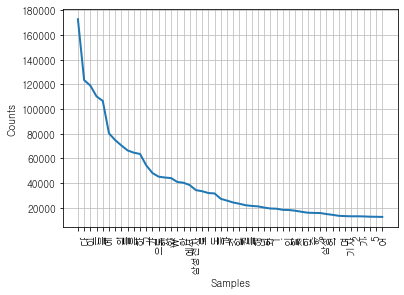

In [11]:
font_fname = 'c:/windows/fonts/gulim.ttc'
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)
ko.plot(50)

In [12]:
stop_words = ['.','가','요','...','을','수','에','질문','제','를','이','도',
              '는','로','으로','2','것','은','다',',','니다','대','들',
              '들','데','..','의','때','겠','고','게','네요','한','일','할',
              '10','?','하는','06','주','려고','인데','거','좀','는데','~','ㅎㅎ',
              '하나','이상','20','뭐','까','있는','습니다','다면','했','주려',
              '지','있','못','후','중','줄','6','과','어떤','기본','!!',
              '단어','고','라고','합','가요','....','보이','네','하','(',')',"\\'",
              '"','·','‘','’','“','”','에서','원','되','기',']','[']

tokens_news = [each_word for each_word in tokens_news if each_word not in stop_words]

ko = nltk.Text(tokens_news, name='뉴스')
data = ko.vocab().most_common(50)
data

[('삼성전자', 34149),
 ('등', 27139),
 ('해', 20969),
 ('년', 19996),
 ('와', 19266),
 ('1', 19098),
 ('인', 18036),
 ('적', 16611),
 ('만', 15851),
 ('%', 15599),
 ('삼성', 14772),
 ('억', 14116),
 ('며', 13096),
 ('기자', 12953),
 ('5', 12562),
 ('어', 12445),
 ('3', 11821),
 ('기업', 11782),
 ('시장', 11411),
 ('0', 11010),
 ('4', 10395),
 ('전', 10114),
 ('사업', 9763),
 ('제품', 9582),
 ('지난해', 9439),
 ('면', 9363),
 ('2020', 9214),
 ('반도체', 9197),
 ('월', 8998),
 ('갤럭시', 8877),
 ('기술', 8764),
 ('된', 8758),
 ('성', 8758),
 ('LG', 8634),
 ('조', 8524),
 ('경제', 8320),
 ('까지', 8310),
 ('한다', 8023),
 ('었', 8004),
 ('미국', 7948),
 ('중국', 7844),
 ('올해', 7597),
 ('면서', 7496),
 ('회장', 7262),
 ('8', 7252),
 ('화', 7142),
 ('투자', 7093),
 ('전자', 7044),
 ('7', 6960),
 ('=', 6860)]

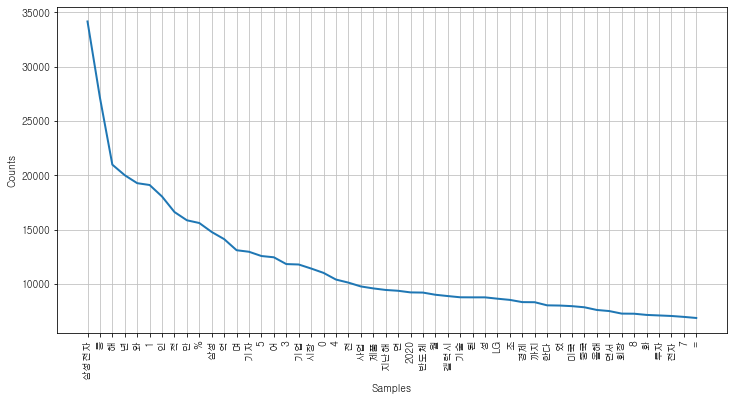

In [18]:
font_fname = 'c:/windows/fonts/gulim.ttc'
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)
plt.figure(figsize=(12, 6))
ko.plot(50)

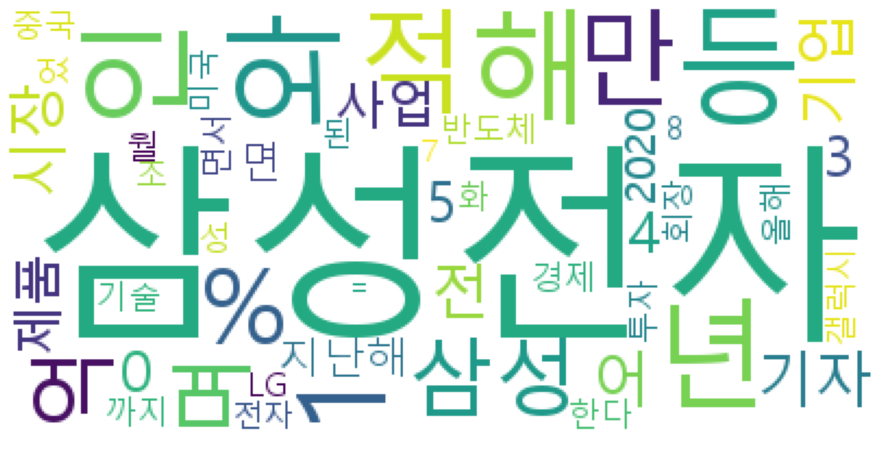

In [13]:
wordcloud = WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',
                      relative_scaling = 0.2,
                      background_color='white'
                      ).generate_from_frequencies(dict(data))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
twitter = Okt()
results = []
lines = news_data

for line in lines:
    malist = twitter.pos(line[0], norm=True, stem=True)
    r= []
    
    for word in malist:
        if not word[1] in ["Josa", "Eomi", "Punctuation"]:
            r.append(word[0])
            
    r1 = (" ".join(r)).strip()
    results.append(r1)
len(results)

In [ ]:
# 데이터 저장
data_file = 'news.data'
with open(data_file, 'w', encoding='utf-8') as fp:
     fp.write("\n".join(results))
# 모델 저장
data = word2vec.LineSentence(data_file)
model = word2vec.Word2Vec(data, vector_size=100, window=10, hs=1, min_count=2, sg=1)
model.save('news.model')

model = word2vec.Word2Vec.load("news.model")
model.wv.most_similar('최고')

In [8]:
def tokenize(doc):
    return [tokens_news for tokens_news in mecab.morphs(doc)]

train = train[:10000]
tokens_news_train = []
tokens_news_train = [tokenize(news[0]) for news in train]

tokens_news_test = []
tokens_news_test = [tokenize(news[0]) for news in test]

# tag를 무엇으로 설정할지
train_texts_and_tags = [
    (text, [f"{i}"]) for i, text in enumerate(tokens_news_train)
]
test_texts_and_tags = [
    (text, [f"{i}"]) for i, text in enumerate(tokens_news_test)
]
TRAIN_documents = [TaggedDocument(words=text, tags=tags) for text, tags in train_texts_and_tags]
TEST_documents = [TaggedDocument(words=text, tags=tags) for text, tags in test_texts_and_tags]


In [11]:
cores = multiprocessing.cpu_count()

#doc2vec parameters
vector_size = 300
window_size = 15
word_min_count = 2
sampling_threshold = 1e-5
negative_size = 5
train_epoch = 100
dm = 1 #0 = dbow; 1 = dmpv
worker_count = cores #number of parallel processes

model = Doc2Vec(TRAIN_documents, vector_size=300, window=5, epochs=40, min_count=2, workers=worker_count, alpha=0.025, min_alpha=0.025)

# To save
model.save('doc2vec.model')

print("##"*20)
print("predicting Document vector")
print("3 Most Simillar Document")
print("##"*20)

# Random Test
doc_id = random.randint(0, len(test) - 1)
new_documents = [tokenize(test[doc_id][0])]
print("Test link:", test[doc_id][1])

# predict training set with its infering vector)
for text in new_documents:
    inferred_v = model.infer_vector(text)
    # 현재 doc를 모델을 사용하여 벡터화할때의 값
    # 기학습된 문서중에서 현재 벡터와 가장 유사한 벡터를 가지는 문서를 topn만큼 추출합니다.
    most_similar_docs = model.dv.most_similar([inferred_v], topn=len(model.dv))
    # index와 그 유사도를 함께 보여줍니다.
    for index, similarity in most_similar_docs[:3]:
        print("tag", train_texts_and_tags[int(index)][1])
        print(f"{index}, similarity: {similarity}")
        print("link:", train[int(index)][1])
    #print(most_similar_docs)
    print("=="*20)
    print("Print Most, Median, Least")
    # Compare and print the most/median/least similar documents from the train corpus
    for label, index in [('MOST', 0), ('MEDIAN', len(most_similar_docs)//2), ('LEAST', len(most_similar_docs) - 1)]:
#         print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words))) -> Word를 보고싶으면 쓰기
        print(u'%s %s\n' % (label, most_similar_docs[index]))

# Tag 정하면 쓸 수 있음
# classifier = LogisticRegression(random_state=1234)
# train_x = [model.infer_vector(doc.words) for doc in TRAIN_documents]
# train_y = [doc.tags[0] for doc in TRAIN_documents]
# test_x = [model.infer_vector(doc.words) for doc in TEST_documents]
# test_y = [doc.tags[0] for doc in TEST_documents]
# classifier.fit(train_x, train_y)
# print(classifier.score(test_x, test_y))

########################################
predicting Document vector
3 Most Simillar Document
########################################
Test link: https://finance.naver.com/news/news_read.nhn?article_id=0001278867&office_id=005&mode=search&query=삼성전자&page=6
tag ['8838']
8838, similarity: 0.733778715133667
link: https://finance.naver.com/news/news_read.nhn?article_id=0000974235&office_id=082&mode=search&query=삼성전자&page=5
tag ['4632']
4632, similarity: 0.65833979845047
link: https://finance.naver.com/news/news_read.nhn?article_id=0003312279&office_id=079&mode=search&query=삼성전자&page=6
tag ['6798']
6798, similarity: 0.6449954509735107
link: https://finance.naver.com/news/news_read.nhn?article_id=0004274790&office_id=015&mode=search&query=삼성전자&page=4
Print Most, Median, Least
MOST ('8838', 0.733778715133667)

MEDIAN ('6218', 0.18356360495090485)

LEAST ('726', -0.0540003702044487)



In [ ]:
model = Doc2Vec.load('doc2vec.model')  # you can continue training with the loaded model!

주가의 등락폭과 하루의 뉴스 총 본문을 엮어서 유사도를 구해봄

In [2]:
def tokenize(doc):
    return [tokens_news for tokens_news in Mecab().morphs(doc)]

df = pd.read_csv('../SamsungMapped2.csv')

news = df['news'].tolist()
changed_price_percent = df['변화량'].tolist()
dates = df['date'].tolist()

# news_data = []
# for i in tqdm(range(len(news))):
#     news_data.append([news[i], changed_price_percent[i]])

tokens_news = [tokenize(n) for n in news ]

texts_and_tags = [
    (text, [change]) for text, change in zip(tokens_news, changed_price_percent)
]
documents = [TaggedDocument(words=text, tags=tags) for text, tags in texts_and_tags]
print('fin')

fin


In [17]:
cores = multiprocessing.cpu_count()

#doc2vec parameters
vector_size = 300
window_size = 15
word_min_count = 2
sampling_threshold = 1e-5
negative_size = 5
train_epoch = 100
dm = 1 #0 = dbow; 1 = dmpv
worker_count = cores #number of parallel processes

model = Doc2Vec(documents, vector_size=300, window=15, epochs=70, min_count=2, workers=worker_count, alpha=0.035, min_alpha=0.020)

# To save
model.save('doc2vec_2_morphs.model')

In [26]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * (np.linalg.norm(b)))

def tokenize(doc):
    return [tokens_news for tokens_news in Mecab().morphs(doc)]

model = Doc2Vec.load('doc2vec_2_morphs.model')  # you can continue training with the loaded model!
tag_list = model.dv.index_to_key
positive_indices = []

for i in range(len(tag_list)):
    if tag_list[i] != '#VALUE!':
        if(float(tag_list[i]) >= 0):
            positive_indices.append(i)
negative_indices = [ i for i in range(len(model.dv)) if i not in positive_indices]

pv = np.mean(model.dv[positive_indices], axis=0)
nv = np.mean(model.dv[negative_indices], axis=0)
print("주가가 오른날 기사 벡터와 주가가 내린날 기사 벡터의 유사도:", cosine_similarity(pv,nv))

# # Random Test
# doc_id = random.randint(0, len(news) - 1)
# new_documents = [tokenize(news[doc_id])]
new_documents = [tokenize(news[3])]
data = pd.DataFrame(dates)

# new_documents = [tokenize(news[i]) for i in range(len(news))]
diff = []

# predict training set with its infering vector)
for text in tqdm(new_documents):
    
    inferred_v = model.infer_vector(text)
#     diff.append(cosine_similarity(inferred_v,pv) - cosine_similarity(inferred_v,nv))

# data['diff'] = diff
# data.columns  = ['date','diff']
# data.to_csv('samsung_news_similiarity')

    # 현재 doc를 모델을 사용하여 벡터화할때의 값
    # 기학습된 문서중에서 현재 벡터와 가장 유사한 벡터를 가지는 문서를 topn만큼 추출합니다.
    most_similar_docs = model.dv.most_similar([inferred_v], topn=len(model.dv))

    print("test 변화량", changed_price_percent[3])
    print("test date",dates[3])
    print()
    # index와 그 유사도를 함께 보여줍니다.
    for tag, similarity in most_similar_docs[:10]:
        print(f"변화량: {tag}, / similarity: {similarity}")
    print('.')
    print('.')
    for tag, similarity in most_similar_docs[len(most_similar_docs)-9:-1]:
        print(f"변화량: {tag}, / similarity: {similarity}")
    print("=="*20)
    print("Most, Median, Least")
    for label, index in [('MOST', 0), ('MEDIAN', len(most_similar_docs)//2), ('LEAST', len(most_similar_docs) - 1)]:
        print(u'%s %s\n' % (label, most_similar_docs[index]))


주가가 오른날 기사 벡터와 주가가 내린날 기사 벡터의 유사도: 0.9979409


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]

test 변화량 -0.01659292
test date 2017-01-04

변화량: -0.01659292, / similarity: 0.871681809425354
변화량: 0.01799775, / similarity: 0.5617280006408691
변화량: 0.000537346, / similarity: 0.5514888763427734
변화량: 0.006987259, / similarity: 0.5359004735946655
변화량: 0.028176796, / similarity: 0.5292305946350098
변화량: -0.005208333, / similarity: 0.5282067656517029
변화량: -0.015486726, / similarity: 0.527633011341095
변화량: 0.005110733, / similarity: 0.5258783102035522
변화량: 0.004214963, / similarity: 0.5231826305389404
변화량: -0.012762763, / similarity: 0.521254301071167
.
.
변화량: 0.013487476, / similarity: 0.3151592016220093
변화량: -0.002152853, / similarity: 0.31486862897872925
변화량: 0.013429752, / similarity: 0.3074018657207489
변화량: 0.010288066, / similarity: 0.3054503798484802
변화량: -0.019933555, / similarity: 0.3035409152507782
변화량: -0.004854369, / similarity: 0.3022266626358032
변화량: 0.018085908, / similarity: 0.297116219997406
변화량: -0.011794139, / similarity: 0.29074400663375854
Most, Median, Least
MOST ('-0.0

LSTM 모델에 넣을 데이터 추출

In [27]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * (np.linalg.norm(b)))

def tokenize(doc):
    return [tokens_news for tokens_news in Mecab().morphs(doc)]

model = Doc2Vec.load('doc2vec_2_morphs.model')  # you can continue training with the loaded model!
tag_list = model.dv.index_to_key
positive_indices = []

for i in range(len(tag_list)):
    if tag_list[i] != '#VALUE!':
        if(float(tag_list[i]) >= 0):
            positive_indices.append(i)
negative_indices = [ i for i in range(len(model.dv)) if i not in positive_indices]

pv = np.mean(model.dv[positive_indices], axis=0)
nv = np.mean(model.dv[negative_indices], axis=0)
print("주가가 오른날 기사 벡터와 주가가 내린날 기사 벡터의 유사도:", cosine_similarity(pv,nv))

# # Random Test
# doc_id = random.randint(0, len(news) - 1)
# new_documents = [tokenize(news[doc_id])]

data = pd.DataFrame(dates)
# new_documents = [tokenize(news[i]) for i in range(len(news))]
diff = []
# predict training set with its infering vector)
for text in tqdm(tokens_news):
    inferred_v = model.infer_vector(text)
    diff.append(cosine_similarity(inferred_v,pv) - cosine_similarity(inferred_v,nv))

data['diff'] = diff
data.columns  = ['date','diff']
data.to_csv('samsung_news_similiarity.csv')

  0%|                                                                                         | 0/1461 [00:00<?, ?it/s]

주가가 오른날 기사 벡터와 주가가 내린날 기사 벡터의 유사도: 0.9979409


100%|██████████████████████████████████████████████████████████████████████████████| 1461/1461 [35:14<00:00,  1.45s/it]
